In [1]:
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

import sys, os

import dynamic_selection as ds

from dynamic_selection import MaskingPretrainer, GreedyDynamicSelection
from torch.distributions import Distribution
Distribution.set_default_validate_args(False)

In [2]:
import random
import numpy as np
import torch
import os

seed = 42

# Python
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# NumPy
np.random.seed(seed)

# PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
# For deterministic behavior on GPU (may slow training)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Data exploration

Here we explore each feature column and comment on how we are going to preprocess each one and what we might consider doing in the future. We have a total of 140700 samples. The last feature is the label depression which we will train on.

## Loading the dataset

In [3]:
# Load the datasets
data_file = 'data/train.csv'
test_file = 'data/test.csv'

data = pd.read_csv(data_file)
test = pd.read_csv(test_file)

print(f"Samples in training set {data.shape[0]}")
print(f"Samples in test set: {test.shape[0]}")

Samples in training set 140700
Samples in test set: 93800


# id Column

In [4]:
# Print examples of the 'id' column
print("Examples of 'id' column:")
print(data["id"].head())

print("")

print("We have " ,data["id"].count()," amount of samples")

Examples of 'id' column:
0    0
1    1
2    2
3    3
4    4
Name: id, dtype: int64

We have  140700  amount of samples


We will drop the id column since there is no correlation between this and the label.

## Name column

In [5]:
# Count occurrences of each unique name
name_counts = data["Name"].value_counts()

# Print results
print("Unique names sorted by count (most to least):")
for name, count in name_counts.items():
    print(f"{name}: {count}")

print(f"Total unique names: {len(name_counts)}")


Unique names sorted by count (most to least):
Rohan: 3178
Aarav: 2336
Rupak: 2176
Aaradhya: 2045
Anvi: 2035
Raghavendra: 1877
Vani: 1657
Tushar: 1596
Ritvik: 1589
Shiv: 1568
Riya: 1548
Rashi: 1547
Raunak: 1524
Anand: 1486
Ishaani: 1477
Ansh: 1423
Vidya: 1408
Ritika: 1313
Anushka: 1279
Sanya: 1272
Aarush: 1266
Aariv: 1254
Abhishek: 1252
Rupal: 1234
Harsha: 1230
Harsh: 1156
Vikram: 1154
Shivam: 1146
Raghav: 1120
Armaan: 1116
Prachi: 1104
Ayaan: 1090
Ivaan: 1090
Siddhesh: 1090
Ira: 1061
Prisha: 1055
Rahil: 1051
Rishi: 1040
Ritik: 1033
Aniket: 1023
Pratham: 1023
Chhavi: 1003
Vibha: 974
Vivan: 963
Aishwarya: 962
Gauri: 959
Nikita: 951
Naina: 946
Veda: 940
Arav: 925
Vidhi: 913
Jiya: 912
Advait: 910
Krishna: 875
Vedant: 872
Ayush: 869
Aditi: 851
Shaurya: 848
Kashish: 845
Gagan: 842
Eshita: 831
Pratyush: 816
Ila: 799
Simran: 790
Aadhya: 787
Shreya: 784
Rudransh: 776
Garima: 769
Yashvi: 767
Anjali: 757
Vihaan: 744
Keshav: 737
Yuvraj: 730
Ishan: 714
Tanisha: 713
Harshil: 712
Sanket: 710
Rajat: 7

We thought about dropping the name column since we thought that this may not have any correlation to the label. But we realised that there might be a correlation, so we decided to keep it. The correlation being that for example having a "unattractive" name can affect your life in a bad way. 


For pre-processing this we will to give a value of how unique it is in the dataset, so for now we change the name with how frequent it is.


Things to consider:

Find a way to "rate" each name instead of how frequent the name is. Impute or change wrong names to missing name.

## Gender

In [6]:
# Print examples of the 'Name' column
print("Examples of 'Name' column:")
print(data["Gender"].head())

print("")

print("Number of unique genders:", data["Gender"].nunique())

Examples of 'Name' column:
0    Female
1      Male
2      Male
3      Male
4    Female
Name: Gender, dtype: object

Number of unique genders: 2


We will just encode male to 1 and female to 0.

## Age

In [7]:
print("Examples of 'Age' column:")
print(data["Age"].head())

print("")

print("Number of unique ages:", data["Age"].nunique())

Examples of 'Age' column:
0    49.0
1    26.0
2    33.0
3    22.0
4    30.0
Name: Age, dtype: float64

Number of unique ages: 43


We will only change the number from float to integer.

## City

In [8]:
print("Examples of 'City' column:")
print(data["City"].head())

print("")

print("Number of unique cities:", data["Age"].nunique())

Examples of 'City' column:
0         Ludhiana
1         Varanasi
2    Visakhapatnam
3           Mumbai
4           Kanpur
Name: City, dtype: object

Number of unique cities: 43


In [9]:
# Count occurrences of each unique city
city_counts = data["City"].value_counts()

# Find first occurrence index for each unique city
first_occurrence = data.groupby("City").apply(lambda x: x.index[0])

# Sort cities by count in descending order
sorted_cities = city_counts.index  # Cities sorted by count (default sorting from most to least)

count = 0
# Print results
print("Unique cities sorted by count (most to least):")
for city in sorted_cities:
    if city_counts[city] > 0:
        count += 1
        print(f"{city}: First Index = {first_occurrence[city]}, Count = {city_counts[city]}")

print(f"Total unique cities: {count}")


Unique cities sorted by count (most to least):
Kalyan: First Index = 36, Count = 6591
Patna: First Index = 9, Count = 5924
Vasai-Virar: First Index = 49, Count = 5765
Kolkata: First Index = 28, Count = 5689
Ahmedabad: First Index = 5, Count = 5613
Meerut: First Index = 17, Count = 5528
Ludhiana: First Index = 0, Count = 5226
Pune: First Index = 13, Count = 5210
Rajkot: First Index = 10, Count = 5207
Visakhapatnam: First Index = 2, Count = 5176
Srinagar: First Index = 26, Count = 5074
Mumbai: First Index = 3, Count = 4966
Indore: First Index = 189, Count = 4872
Agra: First Index = 18, Count = 4684
Surat: First Index = 20, Count = 4636
Varanasi: First Index = 1, Count = 4606
Vadodara: First Index = 43, Count = 4568
Hyderabad: First Index = 23, Count = 4496
Kanpur: First Index = 4, Count = 4398
Jaipur: First Index = 12, Count = 4328
Thane: First Index = 6, Count = 4289
Lucknow: First Index = 16, Count = 4280
Nagpur: First Index = 37, Count = 4209
Bangalore: First Index = 8, Count = 4123
C

C:\Users\elias\AppData\Local\Temp\ipykernel_38924\1198885951.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_occurrence = data.groupby("City").apply(lambda x: x.index[0])


We found population, density, literacy and sex ratio for each major city in our dataset. We then merged this in our data and removed city column. For the minor cities or the wrongly written cities we took the average of the other columns.


To consider:

We should consider adjusting the imputing of the minor and wrongly written cities to for example lower than average.

# Working Professional or Student

In [10]:
print("Examples of 'Working Professional or Student' column:")
print(data["Working Professional or Student"].head())

print("")

print("Number of unique Working Professional or Student:", data["Working Professional or Student"].nunique())

Examples of 'Working Professional or Student' column:
0    Working Professional
1    Working Professional
2                 Student
3    Working Professional
4    Working Professional
Name: Working Professional or Student, dtype: object

Number of unique Working Professional or Student: 2


In this column we will change "working professional" to 0 and "student" to 1.

# Profession

In [11]:
print("Examples of 'Profession' column:")
print(data["Profession"].head())
print("")
print("NaN is student:")
print(data["Profession"][2])
print(data["Working Professional or Student"][2])

print("")

print("Number of unique Profession:", data["Profession"].nunique())



Examples of 'Profession' column:
0                Chef
1             Teacher
2                 NaN
3             Teacher
4    Business Analyst
Name: Profession, dtype: object

NaN is student:
nan
Student

Number of unique Profession: 64


There are occurences of NaN in this column, this happens when the sample is a student. We find it reasonable to insert "Student" in those slots. there are also occurences of NaN on samples that are not students, here we will insert "Missing Profession"

# Academic Pressure

In [12]:
print("Examples of 'Academic pressure' column:")
print(data["Academic Pressure"].head())

print("")

print("Number of unique Academic pressures:", data["Academic Pressure"].nunique())

Examples of 'Academic pressure' column:
0    NaN
1    NaN
2    5.0
3    NaN
4    NaN
Name: Academic Pressure, dtype: float64

Number of unique Academic pressures: 5


For the "Academic Pressure" column we want to replace NaN with zeros.
We are aslo considering merging this feature with work pressure, since they complete eachother. but for now we will have it like this and maybe change it for improving the model later.

# Work pressure

In [13]:
print("Examples of 'Work Pressure' column:")
print(data["Work Pressure"].head())

print("")

print("Number of unique Work Pressure:", data["Work Pressure"].unique())

Examples of 'Work Pressure' column:
0    5.0
1    4.0
2    NaN
3    5.0
4    1.0
Name: Work Pressure, dtype: float64

Number of unique Work Pressure: [ 5.  4. nan  1.  2.  3.]


We assume that a lower number means less work pressure, therefore We will change Nan to 0 because it is the students that has NaN on Work Pressure

# CGPA

In [14]:
print("Examples of 'CGPA' column:")
print(data["CGPA"].head())
print(data["CGPA"].mean())

Examples of 'CGPA' column:
0     NaN
1     NaN
2    8.97
3     NaN
4     NaN
Name: CGPA, dtype: float64
7.658636192558608


We consider changing the NaN slots to the average of the dataset, which is 7.66

# Study Satisfaction and Job Satisfaction (Satisfaction)

In [15]:
print("Examples of 'Study Satisfaction' and 'Job Satisfaction' column:")
print(data["Study Satisfaction"].head())
print(data["Job Satisfaction"].head())

Examples of 'Study Satisfaction' and 'Job Satisfaction' column:
0    NaN
1    NaN
2    2.0
3    NaN
4    NaN
Name: Study Satisfaction, dtype: float64
0    2.0
1    3.0
2    NaN
3    1.0
4    1.0
Name: Job Satisfaction, dtype: float64


You can tell that when there is missing a value in the study satisfaction column, there is a value in the same sample but on the job satisfaction problem. these two columns complete eachother, so we will combine these two columns into one "satisfaction" column.

# Sleep Duration

In [16]:
sleep_counts = data["Sleep Duration"].value_counts()

print("Unique sleep sorted by count (most to least):")
for e, (duration, count) in enumerate(sleep_counts.items()):
    print(duration, count)
    if e == 6:
        break

Unique sleep sorted by count (most to least):
Less than 5 hours 38784
7-8 hours 36969
More than 8 hours 32726
5-6 hours 32142
3-4 hours 12
6-7 hours 8
4-5 hours 7


This one looks a bit tricky. since there are so few occurnces of other than the four most common inputs in this feature, we will change the numbers to a scale from 1 to 4, where 1 is "less than 5 hours" all the way to 4 which is "more than 8 hours". all the others will be set to 1.

# Dietary Habits

In [17]:
diet_counts = data["Dietary Habits"].value_counts()

print("Unique sleep sorted by count (most to least):")
for e, (diet, count) in enumerate(diet_counts.items()):
    print(diet, count)
    if e == 6:
        break

Unique sleep sorted by count (most to least):
Moderate 49705
Unhealthy 46227
Healthy 44741
Yes 2
More Healthy 2
No 2
Pratham 1


* Healthy -> 2
* Moderate -> 1
* Unhealthy -> 0
* The rest -> 1

# Degree

In [18]:
degree_counts = data["Degree"].value_counts()
print(data["Degree"].nunique())

print("Unique sleep sorted by count (most to least):")
for e, (degree, count) in enumerate(degree_counts.items()):
    print(degree, count)
    if e == 10:
        break

115
Unique sleep sorted by count (most to least):
Class 12 14729
B.Ed 11691
B.Arch 8742
B.Com 8113
B.Pharm 5856
BCA 5739
M.Ed 5668
MCA 5234
BBA 5030
BSc 5027
MSc 4879


This one is particularly difficult because there are 115 unique degrees and there are not just a few degrees that covers the majority of the dataset either as the case is in the dietary habit feature. Our approach here is to somehow categorize the different degrees into bachelor, master, doctrine etc. and then give each of them a number from -1 to 4 based on the rank of the degree, going from "other" (which is the case where we can't define what degree it is) to professional.

# Have you ever had suicidal thoughts ?

In [19]:
print("Examples of 'Have you ever had suicidal thoughts ?' column:")
print(data["Have you ever had suicidal thoughts ?"].head())

print("")

print("Number of unique Have you ever had suicidal thoughts ?:", data["Have you ever had suicidal thoughts ?"].nunique())

Examples of 'Have you ever had suicidal thoughts ?' column:
0     No
1    Yes
2    Yes
3    Yes
4    Yes
Name: Have you ever had suicidal thoughts ?, dtype: object

Number of unique Have you ever had suicidal thoughts ?: 2


We will also change this column to binary no / yes to 0 / 1

# Work Study Hours (No prerocessing needed here)

In [20]:
ws_counts = data["Work/Study Hours"].value_counts()
print(data["Work/Study Hours"].nunique())

print("Unique Work/Study Hours sorted by count (most to least):")
for e, (ws, count) in enumerate(ws_counts.items()):
    print(ws, count)
    if e == 20:
        break

13
Unique Work/Study Hours sorted by count (most to least):
10.0 14199
11.0 12832
9.0 12711
0.0 12066
12.0 11409
2.0 10595
6.0 10432
7.0 9872
1.0 9802
3.0 9474
5.0 9337
4.0 9065
8.0 8906


# Financial Stress

In [21]:
finans_count = data["Financial Stress"].value_counts()
print(data["Financial Stress"].nunique())

print("Unique sleep sorted by count (most to least):")
for e, (fn, count) in enumerate(finans_count.items()):
    print(fn, count)
    if e == 10:
        break

5
Unique sleep sorted by count (most to least):
2.0 31451
5.0 28279
4.0 27765
1.0 27211
3.0 25990


Has a few missing values, we will impute the mean in these.

# Family History of Mental Illness

In [22]:
print("Examples of 'Family History of Mental Illness' column:")
print(data["Family History of Mental Illness"].head())

print("")

print("Number of unique Family History of Mental Illnesses:", data["Family History of Mental Illness"].nunique())

Examples of 'Family History of Mental Illness' column:
0     No
1     No
2     No
3    Yes
4    Yes
Name: Family History of Mental Illness, dtype: object

Number of unique Family History of Mental Illnesses: 2


For this column we will change yes and no to 1 and 0

# Depression - The label
Plotting the distribution of the labels

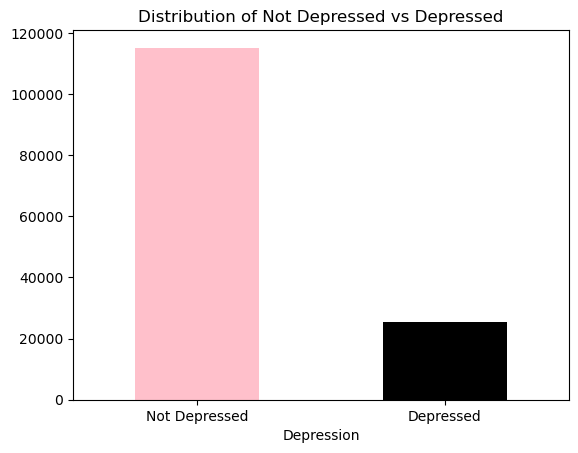

In [23]:
target_counts = data['Depression'].value_counts()
target_counts.plot(kind='bar', color=['pink', 'black'])
plt.xticks(ticks=[0, 1], labels=['Not Depressed', 'Depressed'], rotation=0)
plt.title('Distribution of Not Depressed vs Depressed')
plt.show()

You can tell that there is a significant imbalance between depressed and not depressed. 

# Pre-processing

Dropping the Id column

In [24]:
def dropId(data):
    data = data.drop(columns=["id"])
    return data

Encoding the name column, Replacing each name with its frequency in the dataset

In [25]:
def name_freq(data):
    data["Name"] = data["Name"].map(data["Name"].value_counts())
    return data

Encoding gender column 0/1

In [26]:
def gender_encode(data):
    data["Gender"] = data["Gender"].map({"Female": 0, "Male": 1 })
    return data

Age, changing the type

In [27]:
def age_integer(data):
    data["Age"] = data["Age"].astype(int)
    return data

Academic Preessure, inserting 0 in the empty slots

In [28]:
def academic_pressure(data):
    data["Academic Pressure"] = np.where(
        data["Academic Pressure"].isnull(), 0,
        data["Academic Pressure"]
    )
    return data

Family History of Mental Illnes. -> 0/1

In [29]:
def family_mental_illness(data):
    data["Family History of Mental Illness"] = np.where(
        data["Family History of Mental Illness"] == "No", 0,
        np.where(
            data["Family History of Mental Illness"] == "Yes", 1,
            data["Family History of Mental Illness"]
        )
    )

    # Convert to integer type
    data["Family History of Mental Illness"] = data["Family History of Mental Illness"].astype(int)
    
    return data

Have you ever had suicidal thoughts? -> 0/1

In [30]:
def suicidal_thoughts(data):
    data["Have you ever had suicidal thoughts ?"] = np.where(
        data["Have you ever had suicidal thoughts ?"] == "No", 0,
        np.where(
            data["Have you ever had suicidal thoughts ?"] == "Yes", 1,
            data["Have you ever had suicidal thoughts ?"]
        )
    )
    data["Have you ever had suicidal thoughts ?"] = data["Have you ever had suicidal thoughts ?"].astype(int)
    return data

Financial stress

In [31]:
def financial_stress(data):
    data["Financial Stress"] = np.where(
        data["Financial Stress"].isnull(), round(data["Financial Stress"].mean()), data["Financial Stress"]
    )
    return data

Working Professional or Student. -> 0/1

In [32]:
def working_or_student(data):
    data["Working Professional or Student"] = np.where(
        data["Working Professional or Student"] == "Working Professional", 0,
        np.where(
            data["Working Professional or Student"] == "Student", 1,
            data["Working Professional or Student"]
        )
    )       

    # Convert to integer type
    data["Working Professional or Student"] = data["Working Professional or Student"].astype(int)
    
    return data

Profession. Inserting Student in the empty slots if the sample is a student and missing profession if it is empty and the sample is not a student. also inserting "Missing Profession" in the professions that has less than 10 occurrences in the dataset because the majority of these are wrong information.

In [33]:
def profession(data):
    # Count occurrences of each profession
    profession_counts = data["Profession"].value_counts()
    
    # Update the "Profession" column
    data["Profession"] = np.where(
        data["Profession"].isnull() & (data["Working Professional or Student"] == 1),
        "Student",
        np.where(
            data["Profession"].isnull() & (data["Working Professional or Student"] == 0), 
            "Missing Profession", 
            np.where(
                data["Profession"].map(profession_counts) < 6,  # If occurrence < 10, set to "Missing Profession"
                "Missing Profession",
                data["Profession"]
            )
        )
    )
    return data


Categorizing Professions and giving each category a number. the number is a rating from 0 to 10 on how happy people are in given categories. We used chatGPT to rate them based on different logical points. see professions_mapping dictionary for description of the ratings.

In [34]:
def categorize_profession(profession):
    if pd.isna(profession) or "missing" in profession.lower():
        return "Unknown"
    
    profession = profession.lower().strip()

    # Technology
    tech_keywords = ["software", "data scientist", "ux/ui", "developer", "engineer"]
    if any(keyword in profession for keyword in tech_keywords):
        return "Technology"

    # Finance
    finance_keywords = ["accountant", "financial", "investment", "banker", "analyst"]
    if any(keyword in profession for keyword in finance_keywords):
        return "Finance"

    # Healthcare
    healthcare_keywords = ["doctor", "pharmacist", "dentist", "nurse"]
    if any(keyword in profession for keyword in healthcare_keywords):
        return "Healthcare"

    # Education
    education_keywords = ["teacher", "professor", "educational"]
    if any(keyword in profession for keyword in education_keywords):
        return "Education"

    # Engineering
    engineering_keywords = ["civil engineer", "mechanical engineer", "architect"]
    if any(keyword in profession for keyword in engineering_keywords):
        return "Engineering"

    # Marketing & Sales
    marketing_keywords = ["marketing", "sales", "digital marketer", "content writer"]
    if any(keyword in profession for keyword in marketing_keywords):
        return "Marketing/Sales"

    # Trade & Manual Work
    trade_keywords = ["electrician", "plumber", "chef", "mechanic"]
    if any(keyword in profession for keyword in trade_keywords):
        return "Trade"

    # Legal
    legal_keywords = ["lawyer", "judge", "legal"]
    if any(keyword in profession for keyword in legal_keywords):
        return "Legal"

    # Consulting
    consulting_keywords = ["consultant", "business analyst"]
    if any(keyword in profession for keyword in consulting_keywords):
        return "Consulting"

    # Other / Unknown
    return "Other"

def Prefession_categorization(data):
    # Apply categorization
    data["Profession_Category"] = data["Profession"].apply(categorize_profession)

    # Encoding Options

    ## Option 1: Ordinal Encoding (useful if there's a natural order)
    profession_mapping = {
    "Unknown": 0,           # No data on job satisfaction
    "Other": 4,             # Mixed bag, depends on the job
    "Trade": 6,             # Skilled trades often provide satisfaction, but physically demanding
    "Marketing/Sales": 5,   # High variability, stressful but rewarding
    "Consulting": 5,        # High pay but often high stress & long hours
    "Education": 7,         # Fulfilling, but pay can be low and stress can be high
    "Finance": 6,           # High pay, but long hours and stress
    "Engineering": 7,       # Good pay, problem-solving, but deadlines can be stressful
    "Healthcare": 6,        # Rewarding but high stress and burnout risk
    "Legal": 5,             # High salary, but stressful and demanding
    "Technology": 8         # High salary, flexibility, remote work options
}


    data["Profession_Encoded"] = data["Profession_Category"].map(profession_mapping)

    data["Profession"] = data["Profession_Encoded"]

    data = data.drop(columns=["Profession_Encoded", "Profession_Category"])
    return data
    ## Option 2: One-Hot Encoding (better for categorical data)
    # data = pd.get_dummies(data, columns=["Profession_Category"], prefix="Profession")


Work Pressure

In [35]:
def work_pressure(data):
    data["Work Pressure"] = np.where(
        data["Work Pressure"].isnull(), 0.0, data["Work Pressure"]
    )
    return data

CGPA

In [36]:
def cgpa(data):
    data["CGPA"] = np.where(
        data["CGPA"].isnull(), round(data["CGPA"].mean(), 2), data["CGPA"]
    )
    return data

Study- and Job Satisfaction

In [37]:
def satisfaction(data):
    satisfaction = np.where(
        data["Study Satisfaction"].notnull(), data["Study Satisfaction"], np.where(
            data["Job Satisfaction"].notnull(), data["Job Satisfaction"], 0
        )
    )
    data["Job Satisfaction"] = satisfaction
    data = data.drop(columns="Study Satisfaction")
    data.rename(columns={"Job Satisfaction": "Satisfaction"}, inplace=True)
    return data

Sleep Duration

In [38]:
def sleep_duration(data):
    data["Sleep Duration"] = np.where(
        data["Sleep Duration"] == "Less than 5 hours", 1, np.where(
            data["Sleep Duration"] == "5-6 hours", 2, np.where(
                data["Sleep Duration"] == "7-8 hours", 3, np.where(
                    data["Sleep Duration"] == "More than 8 hours", 4, 1
                )
            )
        )
    )
    return data

Dietary Habits

In [39]:
def diet(data):
    data["Dietary Habits"] = np.where(
        data["Dietary Habits"] == "Healthy", 2, np.where(
            data["Dietary Habits"] == "Moderate", 1, np.where(
                data["Dietary Habits"] == "Unhealthy", 0, 1
            )
        )
    )
    return data

In [40]:
def categorize_degree(degree):

    """
    Categorizes the differnet degrees into Schoo, Bachelors, Masters, Doctrate, professional and other
    """
    
    degree = str(degree).strip().lower()

    # School-Level
    if "class 11" in degree or "class 12" in degree:
        return "School"

    # Bachelor's Degrees
    bachelor_keywords = ["b.", "b ", "bachelor", "bcom", "bsc", "btech", "be", "bba", "bca", "ba", "b.ed", "b.arch"]
    if any(keyword in degree for keyword in bachelor_keywords):
        return "Bachelors"

    # Master's Degrees
    master_keywords = ["m.", "m ", "master", "mba", "mcom", "msc", "mtech", "me", "mca", "m.ed", "mpharm", "m.arch"]
    if any(keyword in degree for keyword in master_keywords):
        return "Masters"

    # Doctoral Degrees
    if "phd" in degree:
        return "Doctorate"

    # Professional Degrees
    professional_keywords = ["mbbs", "md", "llb", "llm"]
    if any(keyword in degree for keyword in professional_keywords):
        return "Professional"

    # Unknown / Noisy Data
    return "Other"

def degree(data):
    
    # Apply categorization
    data["Degree"] = data["Degree"].apply(categorize_degree)


    # Define an ordinal mapping
    degree_mapping = {
        "School": 1,
        "Bachelors": 2,
        "Masters": 3,
        "Professional": 4,
        "Doctorate": 5,
        "Other": 0  # Keep 'Other' at the highest level or remove it depending on the approach
    }

    # Apply mapping
    data["Degree"] = data["Degree"].map(degree_mapping)

    return data 



City

In [41]:
# Load city data
city_data_path = "./Data/indian_cities_data.csv"
df_cities = pd.read_csv(city_data_path)

def city_one_hot(data):
    # Find the index of the "City" column
    city_index = data.columns.get_loc("City")

    # Merge the data with city information, excluding "Main Language"
    merged_data = data.merge(df_cities.drop(columns=["Main Language"]), on="City", how="left")

    # Calculate the mean values for missing cities
    mean_values = merged_data[["Population", "Density (per km²)", "Literacy Rate (%)", "Sex Ratio"]].mean()

    # Replace NaN values with the mean of the respective column
    merged_data.fillna(mean_values, inplace=True)

    # Drop the original "City" column
    merged_data.drop(columns=["City"], inplace=True)

    # Reorder columns to place new city-related columns where "City" was
    city_columns = ["Population", "Density (per km²)", "Literacy Rate (%)", "Sex Ratio"]
    cols = merged_data.columns.tolist()

    # Move the new city-related columns to the correct index
    for col in reversed(city_columns):
        cols.insert(city_index, cols.pop(cols.index(col)))

    # Reorder the dataframe
    merged_data = merged_data[cols]

    return merged_data


Pre-processing function:

In [42]:
def pre_processing(data):

    data = dropId(data)
    data = name_freq(data)
    data = gender_encode(data)
    data = age_integer(data)
    data = academic_pressure(data)
    data = family_mental_illness(data)
    data = suicidal_thoughts(data)
    data = working_or_student(data)
    data = profession(data)
    data = work_pressure(data)
    data = cgpa(data)
    data = satisfaction(data)
    data = sleep_duration(data)
    data = diet(data)
    data = degree(data)
    data = Prefession_categorization(data)
    data = city_one_hot(data)
    data = financial_stress(data)
    return data

train_val = pre_processing(data)
test = pre_processing(test)

Here is The function for Normalizing (0-1) the dataset. This is necessary or helpful if we want to use:

| Learning Algorithm |
|--------------------|
| Logistic Regression |
| SVM |
| Neural Network - better |
| K-Means |

In [43]:
def split_xy(data, target_col="Depression"):
    X = data.drop(columns=[target_col])
    y = data[target_col]
    return X, y


def split_data_train_val(
    data,
    train_size=0.8,
    seed=42,
    stratify=True,
    target_col="Depression"
):
    stratify_arg = data[target_col] if stratify else None
    train_df, val_df = train_test_split(
        data,
        train_size=train_size,
        random_state=seed,
        stratify=stratify_arg
    )
    return train_df, val_df

def normalize_dataset(train_data, test_data):
    # Identify binary columns (values only 0 or 1)
    binary_columns = [col for col in train_data.columns if train_data[col].dropna().isin([0, 1]).all()]
    
    # Identify continuous numerical columns (everything else)
    continuous_columns = [col for col in train_data.columns if col not in binary_columns]

    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Fit on training data only, then transform both training and test data
    train_data_scaled = train_data.copy()
    test_data_scaled = test_data.copy()

    train_data_scaled[continuous_columns] = scaler.fit_transform(train_data[continuous_columns])
    test_data_scaled[continuous_columns] = scaler.transform(test_data[continuous_columns])  # Only transform

    return train_data_scaled, test_data_scaled



def make_specialized(data, target_value):
    """
    Create a specialized dataset for a specific target value.

    Where the data becomes 95% of the target value and 5% of the other target value.
    """
    # Get the target column name
    target_col = "Depression"

    # Create a mask for the target value
    target_mask = data[target_col] == target_value

    # Get the specialized data for the target value
    specialized_data = data[target_mask].copy()

    # Get the other target value
    other_target_value = 1 - target_value

    # Get a sample of 5% from the other target value
    other_data_sample = data[data[target_col] == other_target_value].sample(frac=0.05, random_state=seed)

    # Combine the specialized data with the sampled other data
    combined_data = pd.concat([specialized_data, other_data_sample], ignore_index=True)

    return combined_data


def make_loader(X_tr, y_tr, X_vl, y_vl, batch_size=128):
    # turn into tensors and center by training‐set mean
    X_tr_t = torch.tensor(X_tr.values, dtype=torch.float32)
    mean   = X_tr_t.mean(dim=0, keepdim=True)
    X_tr_t = X_tr_t - mean
    y_tr_t = torch.tensor(y_tr.values, dtype=torch.long)

    X_vl_t = torch.tensor(X_vl.values, dtype=torch.float32) - mean
    y_vl_t = torch.tensor(y_vl.values, dtype=torch.long)

    train_ds = TensorDataset(X_tr_t, y_tr_t)
    val_ds   = TensorDataset(X_vl_t, y_vl_t)

    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size,
                              shuffle=False, drop_last=False)
    return train_loader, val_loader


### Normalizing and splitting the data


We split the data into train val and test.
Further we split the train into bl_train and bl_val  (bl = baselearners)

We also create specialized data where one label is 95% of the label in that dataset.

In [44]:

# Normalize Training and Test Data
train_val, test = normalize_dataset(train_val, test)


# X and y
train_val_X, train_val_y = split_xy(train_val)

# Split train_val into train and val
train, val = split_data_train_val(train_val, train_size=0.8)

# X and y
train_X, train_y = split_xy(train)
val_X, val_y = split_xy(val)


# For base learners
bl_train_val = train.copy()
bl_train_val_happy = make_specialized(bl_train_val,0)
bl_train_val_depressed = make_specialized(bl_train_val, 1)


# X and y
bl_train_val_X, bl_train_val_y = split_xy(bl_train_val)
bl_train_val_happy_X, bl_train_val_happy_y = split_xy(bl_train_val_happy)
bl_train_val_depressed_X, bl_train_val_depressed_y = split_xy(bl_train_val_depressed)


# train and val splits
bl_train, bl_val = split_data_train_val(bl_train_val, train_size=0.8)
bl_train_happy, bl_val_happy = split_data_train_val(bl_train_val_happy, train_size=0.8)
bl_train_depressed, bl_val_depressed = split_data_train_val(bl_train_val_depressed, train_size=0.8)


# X and y for base learners
bl_train_X, bl_train_y = split_xy(bl_train)
bl_val_X, bl_val_y = split_xy(bl_val)

bl_train_happy_X, bl_train_happy_y = split_xy(bl_train_happy)
bl_val_happy_X, bl_val_happy_y = split_xy(bl_val_happy)

bl_train_depressed_X, bl_train_depressed_y = split_xy(bl_train_depressed)
bl_val_depressed_X, bl_val_depressed_y = split_xy(bl_val_depressed)

# Random Forest classifier (base model)

In [45]:
def Random_forest(seed, X_train, y_train):
    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, 30],
        "min_samples_split": [2, 4],
        "min_samples_leaf": [2, 4]
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    rf = RandomForestClassifier(random_state=seed)

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=kf,
        scoring="accuracy",
        n_jobs=-1,  # Use all available CPU cores
        verbose=1   # Shows progress
    )


    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    best_score = grid_search.best_score_
    print(f"Best Score: {best_score:.4f}")

    print("Best Hyperparameters:", best_params)
    
    model = RandomForestClassifier(max_depth=best_params["max_depth"], 
                            min_samples_leaf=best_params["min_samples_leaf"],
                            min_samples_split=best_params["min_samples_split"],
                            n_estimators=best_params["n_estimators"],
                            class_weight="balanced"
                            )

    model.fit(X_train, y_train)
    
    return model, best_score

random_forest_base_model, random_forest_base_model_best_score = Random_forest(seed,train_val_X, train_val_y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Score: 0.9370
Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


# Improved Random Forest classifier - Magnus Paper implementation - implementation in "Magnus_implementation" folder.

[Improved Random forest paper](https://www.sciencedirect.com/science/article/pii/S0957417423020511) <--- link

In [46]:
from Magnus_implementation.ImprovedRandomForest import ImprovedRandomForest

## Hypertune parameters for the improved random forest with grid search method

In [47]:
def hypertuned_model(improved_training_data, X_train, y_train, X_val, y_val):

    parameters = {
        "N_final": [100,200],
        "m": [0.3, 0.7],
        "max_depth": [8,15],
        "min_samples_leaf": [2, 4],
        "min_samples_split": [2, 4]
    }

    # The best parameters from tuning on regular training set
    # parameters = {
    #     "N_final": [200],
    #     "m": [0.7],
    #     "max_depth": [15],
    #     "min_samples_leaf": [4],
    #     "min_samples_split": [2]
    # }

    train_accuracies = []
    val_accuracies = []
    n_estimators = parameters["N_final"]

    # Gives an overview of the computational cost of the hypertuning - for time estamation
    total_candidates = 1
    for p in parameters:
        total_candidates = total_candidates * len(parameters[p])
    print("The total amount of candidates: ", total_candidates)

    best_parameters = {
        "N_final": None,
        "m": None,
        "max_depth": None,
        "min_samples_leaf": None,
        "min_samples_split": None
    }
    best_accuracy_score = 0.0
    best_model = None
    candidates = total_candidates
    for N_final in parameters["N_final"]:
        for m in parameters["m"]:
            for max_depth in parameters["max_depth"]:
                for min_samples_leaf in parameters["min_samples_leaf"]:
                    for min_samples_split in parameters["min_samples_split"]:
                        # print(f"Testing the parameters: {N_final}, {m}, {max_depth}, {min_samples_leaf}, {min_samples_split}.")
                        model = ImprovedRandomForest(N_final, m, max_depth, min_samples_leaf, min_samples_split, improved_training_data)

                        # validationset score
                        val_accuracy = accuracy_score(y_val, model.predict(X_val))
                        val_accuracies.append(val_accuracy)

                        # trainingset score
                        train_accuracy = accuracy_score(y_train, model.predict(X_train))
                        train_accuracies.append(train_accuracy)

                        if val_accuracy > best_accuracy_score:
                            print(f"Best parameters so far: {N_final}, {m}, {max_depth}, {min_samples_leaf}, {min_samples_split}, with accuracy: {round(val_accuracy, 4)}")
                            best_parameters = {
                                "N_final": N_final,
                                "m": m,
                                "max_depth": max_depth,
                                "min_samples_leaf": min_samples_leaf,
                                "min_samples_split": min_samples_split
                            }
                            best_model = model
                            best_accuracy_score = val_accuracy
                        candidates -= 1
                        print(f"Remaining candidates: {candidates}/{total_candidates}")
    print(f"The best performing model with an accuracy score: {round(best_accuracy_score, 4)}, had these parameters:")
    print(f"N_final: {best_parameters['N_final']}\nm: {best_parameters['m']}\nmax_depth: {best_parameters['max_depth']}\nmin_samples_leaf: {best_parameters['min_samples_leaf']}\nmin_samples_split: {best_parameters['min_samples_split']}")
    return best_model, best_parameters, round(best_accuracy_score, 4)


improved_random_forest_model= ImprovedRandomForest(200, 0.7, 15, 4, 2, train_val)

improved_random_forest_model_val_accuracy = accuracy_score(val_y, improved_random_forest_model.predict(val_X))
print(f"Validation accuracy of the improved random forest model: {improved_random_forest_model_val_accuracy:.4f}")


Validation accuracy of the improved random forest model: 0.9361



# Elias's Selection net
## Base learners for selection net:

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.ensemble._weight_boosting")

# Define parameter grids for each model type.
logistic_params = {'C': [0.01, 0.1, 1, 10]}
tree_params = {'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
xgb_params = {'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7], 'n_estimators': [100, 200]}
ada_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.5, 1.0, 1.5]}

# Create dictionaries to hold the specialized learners.
# We want 5 models for depression = 1 (depressed) and 5 for depression = 0 (non-depressed).

specialized_learners = {}

# --- For the Depressed Group (label == 1) ---
# Assume X_special_depr and y_special_depr are the enriched training data for depression=1.
# Logistic Regression specialized for depressed samples.
logistic_depr_grid = GridSearchCV(LogisticRegression(max_iter=1000), logistic_params, cv=5, scoring='accuracy')
logistic_depr_grid.fit(bl_train_val_depressed_X, bl_train_val_depressed_y)
specialized_learners["logistic_depr"] = logistic_depr_grid.best_estimator_
print("Trained logistic_depr with best parameters:", logistic_depr_grid.best_params_)

# Decision Tree specialized for depressed samples.
tree_depr_grid = GridSearchCV(DecisionTreeClassifier(random_state=seed), tree_params, cv=5, scoring='accuracy')
tree_depr_grid.fit(bl_train_val_depressed_X, bl_train_val_depressed_y)
specialized_learners["tree_depr"] = tree_depr_grid.best_estimator_
print("Trained tree_depr with best parameters:", tree_depr_grid.best_params_)

# Random Forest specialized for depressed samples.
rf_depr_grid = GridSearchCV(RandomForestClassifier(random_state=seed), rf_params, cv=5, scoring='accuracy')
rf_depr_grid.fit(bl_train_val_depressed_X, bl_train_val_depressed_y)
specialized_learners["rf_depr"] = rf_depr_grid.best_estimator_
print("Trained rf_depr with best parameters:", rf_depr_grid.best_params_)

# XGBoost specialized for depressed samples.
xgb_depr_grid = GridSearchCV(xgb.XGBClassifier(eval_metric='logloss'), xgb_params, cv=5, scoring='accuracy')
xgb_depr_grid.fit(bl_train_val_depressed_X, bl_train_val_depressed_y)
specialized_learners["xgb_depr"] = xgb_depr_grid.best_estimator_
print("Trained xgb_depr with best parameters:", xgb_depr_grid.best_params_)

# AdaBoost specialized for depressed samples.
ada_depr_grid = GridSearchCV(AdaBoostClassifier(algorithm='SAMME', random_state=seed), ada_params, cv=5, scoring='accuracy')
ada_depr_grid.fit(bl_train_val_depressed_X, bl_train_val_depressed_y)
specialized_learners["ada_depr"] = ada_depr_grid.best_estimator_
print("Trained ada_depr with best parameters:", ada_depr_grid.best_params_)


print("\n")

# --- For the Non-Depressed Group (label == 0) ---
# Assume X_special_non_depr and y_special_non_depr are the enriched training data for depression=0.
# Logistic Regression specialized for non-depressed samples.
logistic_non_depr_grid = GridSearchCV(LogisticRegression(max_iter=1000), logistic_params, cv=5, scoring='accuracy')
logistic_non_depr_grid.fit(bl_train_val_happy_X, bl_train_val_happy_y)
specialized_learners["logistic_nondepr"] = logistic_non_depr_grid.best_estimator_
print("Trained logistic_nondepr with best parameters:", logistic_non_depr_grid.best_params_)

# Decision Tree specialized for non-depressed samples.
tree_non_depr_grid = GridSearchCV(DecisionTreeClassifier(random_state=seed), tree_params, cv=5, scoring='accuracy')
tree_non_depr_grid.fit(bl_train_val_happy_X, bl_train_val_happy_y)
specialized_learners["tree_nondepr"] = tree_non_depr_grid.best_estimator_
print("Trained tree_nondepr with best parameters:", tree_non_depr_grid.best_params_)

# Random Forest specialized for non-depressed samples.
rf_non_depr_grid = GridSearchCV(RandomForestClassifier(random_state=seed), rf_params, cv=5, scoring='accuracy')
rf_non_depr_grid.fit(bl_train_val_happy_X, bl_train_val_happy_y)
specialized_learners["rf_nondepr"] = rf_non_depr_grid.best_estimator_
print("Trained rf_nondepr with best parameters:", rf_non_depr_grid.best_params_)

# XGBoost specialized for non-depressed samples.
xgb_non_depr_grid = GridSearchCV(xgb.XGBClassifier(eval_metric='logloss'), xgb_params, cv=5, scoring='accuracy')
xgb_non_depr_grid.fit(bl_train_val_happy_X, bl_train_val_happy_y)
specialized_learners["xgb_nondepr"] = xgb_non_depr_grid.best_estimator_
print("Trained xgb_nondepr with best parameters:", xgb_non_depr_grid.best_params_)

# AdaBoost specialized for non-depressed samples.
ada_non_depr_grid = GridSearchCV(AdaBoostClassifier(algorithm='SAMME', random_state=seed), ada_params, cv=5, scoring='accuracy')
ada_non_depr_grid.fit(bl_train_val_happy_X, bl_train_val_happy_y)
specialized_learners["ada_nondepr"] = ada_non_depr_grid.best_estimator_
print("Trained ada_nondepr with best parameters:", ada_non_depr_grid.best_params_)

print("\nTotal specialized base learners trained:", len(specialized_learners))

Trained logistic_depr with best parameters: {'C': 10}
Trained tree_depr with best parameters: {'max_depth': 5, 'min_samples_split': 2}
Trained rf_depr with best parameters: {'max_depth': None, 'n_estimators': 100}
Trained xgb_depr with best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Trained ada_depr with best parameters: {'learning_rate': 1.5, 'n_estimators': 200}


Trained logistic_nondepr with best parameters: {'C': 1}
Trained tree_nondepr with best parameters: {'max_depth': 5, 'min_samples_split': 2}
Trained rf_nondepr with best parameters: {'max_depth': 20, 'n_estimators': 200}
Trained xgb_nondepr with best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Trained ada_nondepr with best parameters: {'learning_rate': 1.5, 'n_estimators': 200}

Total specialized base learners trained: 10


Tuning selection network...
Training for k=1...
Epoch 1/5...
Epoch 2/5...
Epoch 3/5...
Epoch 4/5...
Epoch 5/5...
Training for k=2...
Epoch 1/5...
Epoch 2/5...
Epoch 3/5...
Epoch 4/5...
Epoch 5/5...
Training for k=3...
Epoch 1/5...
Epoch 2/5...
Epoch 3/5...
Epoch 4/5...
Epoch 5/5...
Training for k=4...
Epoch 1/5...
Epoch 2/5...
Epoch 3/5...
Epoch 4/5...
Epoch 5/5...
Training for k=5...
Epoch 1/5...
Epoch 2/5...
Epoch 3/5...
Epoch 4/5...
Epoch 5/5...
Training for k=6...
Epoch 1/5...
Epoch 2/5...
Epoch 3/5...
Epoch 4/5...
Epoch 5/5...
Training for k=7...
Epoch 1/5...
Epoch 2/5...
Epoch 3/5...
Epoch 4/5...
Epoch 5/5...
Training for k=8...
Epoch 1/5...
Epoch 2/5...
Epoch 3/5...
Epoch 4/5...
Epoch 5/5...
Training for k=9...
Epoch 1/5...
Epoch 2/5...
Epoch 3/5...
Epoch 4/5...
Epoch 5/5...
Training for k=10...
Epoch 1/5...
Epoch 2/5...
Epoch 3/5...
Epoch 4/5...
Epoch 5/5...


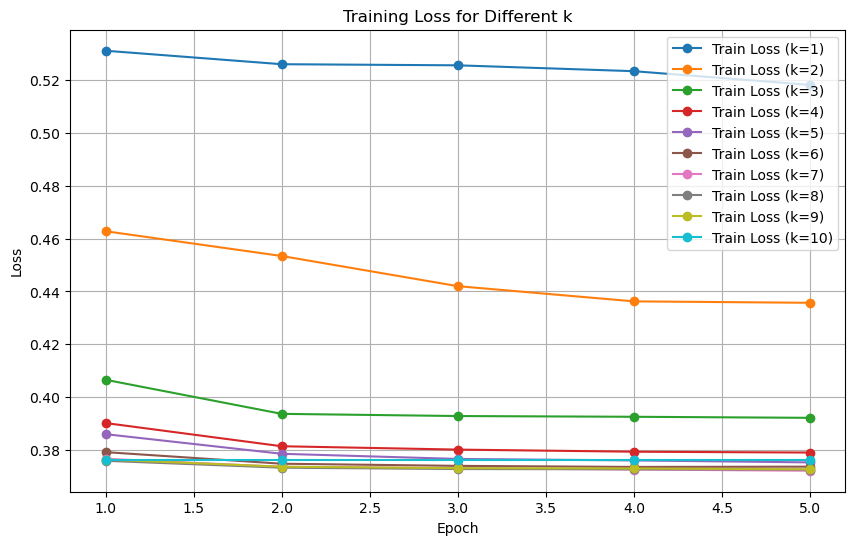

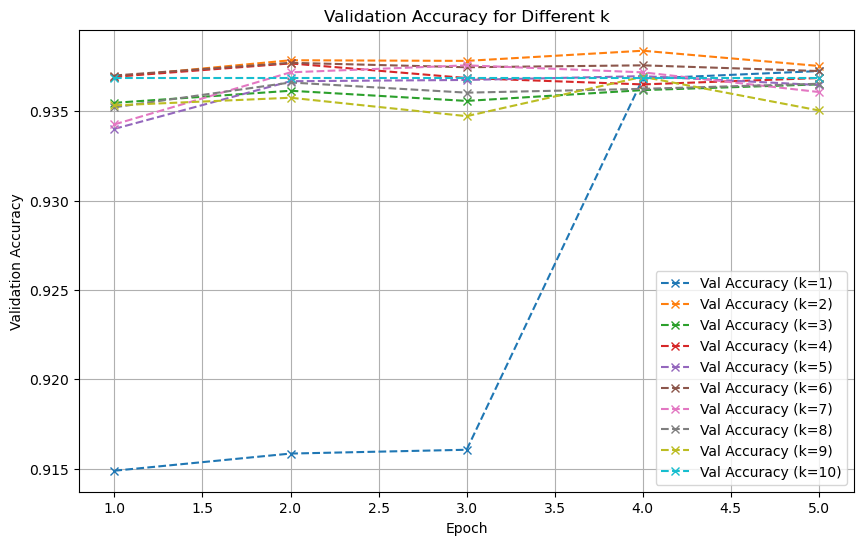

Best k=2 with validation accuracy=0.9384


In [49]:
# Default selection net (Elias's paper alone)

import importlib
import selection_net_module

# re-read the .py file and replace the module in memory
importlib.reload(selection_net_module)

from selection_net_module import SelectionNetwork, ensemble_forward, get_base_predictions, tune_selection_net


ks = [1,2,3,4,5,6,7,8,9,10]

feature_dim = train_X.shape[1]

epoch = 5


best_k_special, best_acc, best_state_special, results, losses, accs = tune_selection_net(
    specialized_learners, train_X, train_y, val_X, val_y,
    ks, feature_dim, num_epochs=epoch, epsilon=0.1, m=1000, batch_size=512, plot=True
)

print(f"Best k={best_k_special} with validation accuracy={best_acc:.4f}")

# Greedy dynamic feature selection - Isak paper implementation - Implementation in "dynamic_selection" folder

[Greedy Dynamic Feature Slection](https://proceedings.mlr.press/v202/covert23a/covert23a.pdf) <--- Link



## Greedy dynamic feature selection - Isak Paper

### Making tensors and loaders

### Instantiate the net and pretraining

In [50]:
# Creating the dataloaders for greedy dynamic selection

batch_size = 128

# Full original split
train_loader,   val_loader   = make_loader(
    train_X,   train_y,
    val_X,     val_y,
    batch_size)

In [51]:
input_size = 20
output_size = 2 
dropout_rate = 0.4
hidden_size = 64


predicting_net= nn.Sequential(
    nn.Linear(2*input_size,hidden_size),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(hidden_size,hidden_size),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(hidden_size,output_size))

selecting_net = nn.Sequential(
    nn.Linear(2 * input_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(dropout_rate),
    nn.Linear(hidden_size, input_size ))


mask_layer_full_model = ds.utils.MaskLayer(append=True)


print(' Running full model')
pretrain_full = MaskingPretrainer(predicting_net, mask_layer_full_model)
pretrain_full.fit(
    train_loader,
    val_loader,
    lr=1e-3,
    nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

 Running full model


x:\Anaconda\envs\367A\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


--------Epoch 1--------
Val loss = 0.2836

--------Epoch 2--------
Val loss = 0.2833

--------Epoch 3--------
Val loss = 0.2765

--------Epoch 4--------
Val loss = 0.2775

--------Epoch 5--------
Val loss = 0.2762

--------Epoch 6--------
Val loss = 0.2773

--------Epoch 7--------
Val loss = 0.2741

--------Epoch 8--------
Val loss = 0.2741

--------Epoch 9--------
Val loss = 0.2740

--------Epoch 10--------
Val loss = 0.2716

--------Epoch 11--------
Val loss = 0.2719

--------Epoch 12--------
Val loss = 0.2720

--------Epoch 13--------
Val loss = 0.2710

--------Epoch 14--------
Val loss = 0.2692

--------Epoch 15--------
Val loss = 0.2685

--------Epoch 16--------
Val loss = 0.2707

--------Epoch 17--------
Val loss = 0.2736

--------Epoch 18--------
Val loss = 0.2734

--------Epoch 19--------
Val loss = 0.2684

--------Epoch 20--------
Val loss = 0.2688

--------Epoch 21--------
Val loss = 0.2669

--------Epoch 22--------
Val loss = 0.2691

--------Epoch 23--------
Val loss = 0.269

## Training

In [52]:
gdfs_full_model = GreedyDynamicSelection(selecting_net, predicting_net, mask_layer_full_model)
print(' Running full model')
gdfs_full_model.fit(
    train_loader,
    val_loader,
    lr=1e-3,
    nepochs=3,
    max_features=20,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

 Running full model
Starting training with temp = 1.0000

--------Epoch 1 (1 total)--------
Val loss = 0.1709, Zero-temp loss = 0.1760

--------Epoch 2 (2 total)--------
Val loss = 0.1728, Zero-temp loss = 0.1784

--------Epoch 3 (3 total)--------
Val loss = 0.1706, Zero-temp loss = 0.1767

Stopping temp = 1.0000 at epoch 3

Starting training with temp = 0.5623

--------Epoch 1 (4 total)--------
Val loss = 0.1709, Zero-temp loss = 0.1742

--------Epoch 2 (5 total)--------
Val loss = 0.1709, Zero-temp loss = 0.1743

--------Epoch 3 (6 total)--------
Val loss = 0.1724, Zero-temp loss = 0.1766

Stopping temp = 0.5623 at epoch 3

Starting training with temp = 0.3162

--------Epoch 1 (7 total)--------
Val loss = 0.1716, Zero-temp loss = 0.1720

--------Epoch 2 (8 total)--------
Val loss = 0.1781, Zero-temp loss = 0.1786

--------Epoch 3 (9 total)--------
Val loss = 0.1716, Zero-temp loss = 0.1725

Stopping temp = 0.3162 at epoch 3

Starting training with temp = 0.1778

--------Epoch 1 (10 t

In [54]:
# Testing the val accuracy of the full model
# val_acc_full = gdfs_full_model.score(val_loader)


# Combined selection net

In [55]:
# Base learners dataloaders
# 1) Depressed
bl_dep_train_loader,    bl_dep_val_loader    = make_loader(
    bl_train_depressed_X, bl_train_depressed_y, bl_val_depressed_X, bl_val_depressed_y, batch_size)

# 2) Happy
bl_happy_train_loader,  bl_happy_val_loader  = make_loader(
    bl_train_happy_X, bl_train_happy_y, bl_val_happy_X, bl_val_happy_y, batch_size)

# 3) bs_train and bs_val
bl_train_loader,    bl_val_loader    = make_loader(
    bl_train_X, bl_train_y,
    bl_val_X,   bl_val_y,
    batch_size)



bl_mask_layer_happy = ds.utils.MaskLayer(append=True)

bl_mask_layer_dep = ds.utils.MaskLayer(append=True)

bl_mask_layer_full = ds.utils.MaskLayer(append=True)


# Pretraining

print(' Running Happy')
pretrain_happy = MaskingPretrainer(predicting_net, bl_mask_layer_happy)
pretrain_happy.fit(
    bl_happy_train_loader,
    bl_happy_val_loader,
    lr=1e-3,
    nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

print(' Running depressed')
pretrain_dep = MaskingPretrainer(predicting_net, bl_mask_layer_dep)
pretrain_dep.fit(
    bl_dep_train_loader,
    bl_dep_val_loader,
    lr=1e-3,
    nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)


print(' Running subtrain')
pretrain_sub = MaskingPretrainer(predicting_net, bl_mask_layer_full)
pretrain_sub.fit(
    bl_train_loader,
    bl_val_loader,
    lr=1e-3,
    nepochs=100,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)


# Training

bl_gdfs_happy = GreedyDynamicSelection(selecting_net, predicting_net, bl_mask_layer_happy)
print(' Running Happy')
bl_gdfs_happy.fit(
    bl_happy_train_loader,
    bl_happy_val_loader,
    lr=1e-3,
    nepochs=3,
    max_features=20,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

bl_gdfs_dep = GreedyDynamicSelection(selecting_net, predicting_net, bl_mask_layer_dep)
print(' Running depressed')
bl_gdfs_dep.fit(
    bl_dep_train_loader,
    bl_dep_val_loader,
    lr=1e-3,
    nepochs=3,
    max_features=20,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)

bl_gdfs_sub = GreedyDynamicSelection(selecting_net, predicting_net, bl_mask_layer_full)
print(' Running subtrain')
bl_gdfs_sub.fit(
    bl_train_loader,
    bl_val_loader,
    lr=1e-3,
    nepochs=3,
    max_features=20,
    loss_fn=nn.CrossEntropyLoss(),
    verbose=True)



 Running Happy
--------Epoch 1--------
Val loss = 0.0442

--------Epoch 2--------
Val loss = 0.0446

--------Epoch 3--------
Val loss = 0.0439

--------Epoch 4--------
Val loss = 0.0456

--------Epoch 5--------
Val loss = 0.0427

--------Epoch 6--------
Val loss = 0.0444

--------Epoch 7--------
Val loss = 0.0417

--------Epoch 8--------
Val loss = 0.0436

--------Epoch 9--------
Val loss = 0.0449

--------Epoch 10--------
Val loss = 0.0435

--------Epoch 11--------
Val loss = 0.0430

Stopping early at epoch 11
 Running depressed
--------Epoch 1--------
Val loss = 0.3499

--------Epoch 2--------
Val loss = 0.3011

--------Epoch 3--------
Val loss = 0.2865

--------Epoch 4--------
Val loss = 0.2701

--------Epoch 5--------
Val loss = 0.2817

--------Epoch 6--------
Val loss = 0.2865

--------Epoch 7--------
Val loss = 0.2847

--------Epoch 8--------
Val loss = 0.2794

Stopping early at epoch 8
 Running subtrain
--------Epoch 1--------
Val loss = 0.2666

--------Epoch 2--------
Val loss 

In [56]:
class GreedyProbaWrapper:
    def __init__(self, greedy_model, max_features=20):
        # force the underlying model (and its helper device) to CPU
        self.greedy = greedy_model.cpu()
        self.max_features = max_features

    def predict_proba(self, X):
        # turn X into a plain numpy array
        X_arr = X.values if hasattr(X, "values") else X
        # build a CPU tensor (so m = zeros(...) also lands on CPU)
        X_t   = torch.tensor(X_arr, dtype=torch.float32)  
        # forward returns (logits, mask, m)
        logits, mask, m = self.greedy(X_t, self.max_features)
        # sigmoid → probabilities
        probs = torch.sigmoid(logits)
        # back to numpy
        return probs.detach().cpu().numpy()


# Creating three base learners from greedy dynamic selection
# 1) Full dataset
bl_greedy_wrapped_full_sub = GreedyProbaWrapper(bl_gdfs_sub, max_features=20)

# 2) Depressed dataset
bl_greedy_wrapped_dep = GreedyProbaWrapper(bl_gdfs_dep, max_features=20)

# 3) Happy dataset
bl_greedy_wrapped_happy = GreedyProbaWrapper(bl_gdfs_happy, max_features=20)

In [ ]:
# Creating three different base learners from improved random forest
# 1) For the full dataset
bl_improved_random_forest, _, _ = hypertuned_model(bl_train_val, bl_train_X, bl_train_y, bl_val_X, bl_val_y)

# 2) For the depressed group
bl_improved_random_forest_dep,_ ,_ = hypertuned_model(bl_train_val_depressed, bl_train_depressed_X, bl_train_depressed_y, bl_val_depressed_X, bl_val_depressed_y)

# 3) For the happy group
bl_improved_random_forest_happy,_ ,_ = hypertuned_model(bl_train_val_happy, bl_train_happy_X, bl_train_happy_y, bl_val_happy_X, bl_val_happy_y)


# Creating three different base learners from the default random forest
# 1) For the full dataset
bl_base_model_random_forest,_ = Random_forest(seed, bl_train_val_X, bl_train_val_y)

# 2) For the depressed group
bl_base_model_random_forest_depressed,_ = Random_forest(seed, bl_train_val_depressed_X, bl_train_val_depressed_y)

# 3) For the happy group
bl_base_model_random_forest_happy,_ = Random_forest(seed, bl_train_val_happy_X, bl_train_val_happy_y)



# Creating a dictionary of all the base learners
combined_base_learners = {
    "base model Random Forest": bl_base_model_random_forest,
    "base model Random Forest depr": bl_base_model_random_forest_depressed,
    "base model Random Forest happy": bl_base_model_random_forest_happy,
    "improved random forest": bl_improved_random_forest,
    "improved random forest depr": bl_improved_random_forest_dep,
    "improved random forest happy": bl_improved_random_forest_happy,
    "greedy": bl_greedy_wrapped_full_sub,
    "greedy depressed": bl_greedy_wrapped_dep,
    "greedy happy": bl_greedy_wrapped_happy
}

The total amount of candidates:  32


In [ ]:
# Combined selection net where we use magnus paper, isaks paper and our base model as base learners -> 9 base learners

ks = [1,2,3,4,5,6,7,8,9]

feature_dim = train_X.shape[1]

epoch = 5

best_k_combined, best_acc, best_state_combined, results, losses, accs = tune_selection_net(
    combined_base_learners, train_X, train_y, val_X, val_y,
    ks, feature_dim, num_epochs=epoch, epsilon=0.1, m=1000, batch_size=512,plot= True
)

print(f"Best k={best_k_combined} with validation accuracy={best_acc:.4f}")

Tuning selection network...
Training for k=1...


AttributeError: 'tuple' object has no attribute 'predict_proba'

# Model selection

### Plot all the different models accuracy on validations

### Go further with the best one:

In [ ]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
from selection_net_module import SelectionNetwork, get_base_predictions, ensemble_forward


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Helper to evaluate a tuned SelectionNet
def evaluate_selection_net(net_state, base_learners, best_k,
                           X_val, y_val, feature_dim, epsilon=0.1, m=1000):
    # rebuild & load
    net = SelectionNetwork(input_size=feature_dim, num_learners=len(base_learners))
    net.load_state_dict(net_state)
    net.to(device).eval()
    # prepare tensors
    X_t   = torch.tensor(X_val.values if hasattr(X_val, 'values') else X_val,
                         dtype=torch.float32, device=device)
    bp_np = get_base_predictions(X_val, base_learners)
    bp_t  = torch.tensor(bp_np, dtype=torch.float32, device=device)
    # forward & accuracy
    with torch.no_grad():
        probs = ensemble_forward(net, X_t, bp_t, best_k, epsilon, m)
        preds = probs.argmax(dim=1).cpu().numpy()
    return accuracy_score(y_val, preds)

# Torch‐based accuracy metric for greedy model
def torch_acc(preds, labels):
    if preds.ndim > 1:
        preds = preds.argmax(dim=1)
    return (preds == labels).float().mean()



# List of models to test
models_to_test = [
    ("SelNet-Special",   "Selection",      best_state_special, specialized_learners,   best_k_special,   0.1, 1000),
    ("SelNet-Combined",  "Selection",      best_state_combined,combined_base_learners,best_k_combined,  0.1, 1000),
    ("Magnus Imp. RF",   "Random Forest",  improved_random_forest_model,                None,                  None,            None, None),
    ("Isak Greedy",      "Neural Network", gdfs_full_model,          None,                  None,            None, None),
    ("Base RF",          "Random Forest",  random_forest_base_model,         None,                  None,            None, None),
]


# Run evaluation loop
results = {}
feature_dim = train_X.shape[1]

for name, mtype, obj, learners, k, eps, m in models_to_test:
    if mtype == "Selection":
        acc = evaluate_selection_net(
            obj, learners, k,
            val_X, val_y,
            feature_dim, epsilon=eps, m=m
        )
    elif name == "Base RF":
        acc = random_forest_base_model_best_score
    elif name == "Magnus Imp. RF":
        acc = improved_random_forest_model_val_accuracy
    
    elif mtype == "Neural Network":
        acc = obj.evaluate(
            loader=val_loader,
            max_features=20,
            metric=torch_acc,
            argmax=True
        )
    else:
        raise ValueError(f"Unknown model type {mtype}")
    results[name] = acc

# Print summary
for name, acc in results.items():
    print(f"{name:20s} → Val accuracy: {acc:.4f}")

best_name = max(results, key=results.get)
print(f"\nBest performing model: {best_name} with accuracy {results[best_name]:.4f}")


SelNet-Special       → Val accuracy: 0.9382
SelNet-Combined      → Val accuracy: 0.9383
Magnus Imp. RF       → Val accuracy: 0.9666
Isak Greedy          → Val accuracy: 0.8186
Base RF              → Val accuracy: 0.9346

Best performing model: Magnus Imp. RF with accuracy 0.9666


# Going further with the best model

In [ ]:
def inference(model, test_data):
        predictions = model.predict(test_data)

        submission = pd.DataFrame({
            "id": test["id"], 
            "Depression": predictions
        })
        submission.to_csv("submission.csv", index=False)
        print("test successfully executed, results in submission.csv")
